#### Tutorial Joint Final Project: Deep Learning and Quantum Information Theory

### Quantum Code Generation using Conditional RNNs
_Yoav Rabinovich, December 2019_

--------------------------

#### Installs and imports

In [1]:
!pip install qiskit
!pip install tensorflow-gpu --upgrade
!pip install -Iv cond-rnn==1.4

     |████████████████████████████████| 2.9MB 4.6MB/s 
     |████████████████████████████████| 23.0MB 131kB/s 
     |████████████████████████████████| 143kB 71.0MB/s 
     |████████████████████████████████| 102kB 16.1MB/s 
     |████████████████████████████████| 1.8MB 63.9MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 5.6MB 41.0MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 153kB 68.2MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 71kB 13.0MB/s 
     |████████████████████████████████| 24.3MB 100kB/s 
     |████████████████████████████████| 573kB 54.0MB/s 
     |████████████████████████████████| 2.3MB 69.0MB/s 
  Created wheel for qiskit: filename=qiskit-0.16.2-cp36-none-any.whl size=2898 sha256=865d203d519eb78bc0f123995bcb8d77e947a52f2fbf8174fc2b9f5fc4dcdcfa
  Stored in directory: /root/.cache/pip/wheels/8d/eb/5a/ce0d4fa7714b1b698

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit as qk
import tensorflow.compat.v1 as tf
import cond_rnn as crnn
import re
import os
from google.colab import output
tf.disable_v2_behavior()
qs_backend = qk.Aer.get_backend('statevector_simulator')

Instructions for updating:
non-resource variables are not supported in the long term


#### Circuit Functions

In [0]:
def sample_circuits(n,size,amount):
    """Sample an amount of random n-qubit circuits with a certain size in
    number of operations from the allowed set"""

    circuits =[]
    for _ in range(amount):
        # Create circuit object of n qubits
        circ = qk.QuantumCircuit(n)
        # Generate random gates on random qubits from the universal set {H,S,CX}
        for _ in range(size):
            gate = np.random.randint(0,3)
            target = np.random.randint(0,n)
            if gate==0: # Hadamard
                circ.h(target)
            if gate==1: # S-gate
                circ.s(target)
            if gate==2: # CNOT
                control = np.random.randint(0,n)
                if control == target:
                    circ.h(target)
                else:
                    circ.cx(control,target)
        circuits.append(circ)
    return circuits

def encode_circuits(circuits,n,max_size,label=True):
    """Takes an array of n-qubit QuantumCircuit objects, and encodes them based on a
    vocabulary of possible gates to apply, including tokens to signify the start
    and end of sequences. Elements after EoS are padded to match maximum circuit
    size using a special token.
    Labels can be also be generated for the circuits."

    Vocabulary scheme:
    Padding = 0,
    SoS = 1,
    EoS = 2,
    h[0]=3, h[1]=3+1...
    s[0]=3+n, s[1]=3+n+1...
    cx[0,0]=3+2n, cx[0,1]=3+2n+1...
    cx[1,0]=3+(2+1)n, cx[1,1]=3+(2+1)n+1... etc. """

    encoded = []
    for circ in circuits:
        # Use the QASM format to convert the circuit to a string
        lines = circ.qasm().splitlines()[3:]
        size = len(lines)
        # Initialize to padding tokens
        encoded_circ = np.zeros(max_size+2)
        # Add SoS and EoS tokens
        encoded_circ[0] = 1
        encoded_circ[size+1]=2
        for i,line in enumerate(lines):
            # Detect gate name and qubits involved
            gate_str = line[:2]
            integers = [int(s) for s in re.findall(r'-?\d+\.?\d*',line)]
            # Encode gates based on scheme above
            if gate_str=="h ":
                encoded_circ[i+1]=int(3+integers[0])
            if gate_str=="s ":
                encoded_circ[i+1]=int(3+n+integers[0])
            if gate_str=="cx":
                encoded_circ[i+1]=int(3+(2+integers[0])*n+integers[1])
        encoded.append(encoded_circ)
    encoded = np.array(encoded)
    if label:
        # Simulate labels for each circuit and attach to dataset
        labels = generate_labels(circuits)
        return np.concatenate((encoded,labels),axis=1)
    else:
        return np.array(encoded)

def decode_circuit(encoded,n,debug=False):
    """Takes an encoded output from the network and generates the corresponding
    circuit as described above."""

    # Start with opening syntax
    decoded = "OPENQASM 2.0;\ninclude \"qelib1.inc\";\nqreg q["+str(n)+"];\n"
    for line in encoded:
        # decode each non-token element into its QASM string
        line = int(np.around(line))
        if debug: print(line)
        if line > 2:
            gate_num = int(np.ceil((line-2)/n))
            if debug: print(gate_num)
            if gate_num==1:
                decoded += "h q["+str(line-3)+"];\n"
            elif gate_num==2:
                decoded += "s q["+str(line-n-3)+"];\n"
            elif (str(gate_num-3)!=str(line-(gate_num-1)*n-3)):
                decoded += "cx q["+str(gate_num-3)+"],q["+str(line-(gate_num-1)*n-3)+"];\n"
        if line == 2:
            decoded = decoded[:-1]
            break
        if debug: print(decoded)
    if debug:
        print(decoded)
    # Build circuit object from QASM string
    return qk.QuantumCircuit.from_qasm_str(decoded)

#### Preparation


##### Parameters

In [0]:
# Model Parameters
N = 5 # size of qubit register
MAX_LENGTH = 10 # maximum length of gate sequence
VOCAB_DIM = 2+2*N+N**2 # amount of possible gates
NUM_SAMPLES = 10000 # number of circuits in the database
TRAINTEST = 0.75 # proportion of training data
CUTOFF = int(NUM_SAMPLES//2)#(1/TRAINTEST))
TIME_STEPS = MAX_LENGTH+2 # length of sequence including tokens
INPUT_DIM = 1 # size of input element
LABEL_DIM = 1 # size of label element
COND_DIM = 2*(2**N) # length of condition state
NUM_CELLS = 256 # number of cells in each RNN layer
STACK_DEPTH = 5 # number of stacked RNN layers
NUM_DENSE = 64 # size of dense classification layers
CLASS_DEPTH = 5 # number of stacked classification layers
LOSS_DELAY = 10 # number of epochs between each loss recording
PRINT_DELAY = 10 # number of recordings between each loss printing
SAVE_DELAY = 10000 # number of epochs between each model checkpoint

# Training Parameters
BATCH_SIZE = 64
EPOCHS = 1000 # hard cutoff for training

# Model Structure
ONE_HOT = True
INPUT_CONCATENATED = False

# Correct input dimensions
if ONE_HOT:
    INPUT_DIM = VOCAB_DIM
    LABEL_DIM = VOCAB_DIM

if INPUT_CONCATENATED:
    INPUT_DIM += COND_DIM

##### Generate Data (Option)

In [0]:
# Generate Data
# Data = encode_circuits(sample_circuits(N,MAX_LENGTH,NUM_SAMPLES),N,MAX_LENGTH,label=True)
# Save Data
# np.savetxt(f"Encoded_Circuits_{str(N)}_{str(MAX_LENGTH)}_{str(NUM_SAMPLES)}.csv", Data, delimiter=",")

##### Load Data (Option)

In [0]:
# Load Data
Data = np.loadtxt(f"Encoded_Circuits_{str(N)}_{str(MAX_LENGTH)}_{str(NUM_SAMPLES)}.csv", delimiter=",")

##### Data Preprocessing

In [0]:
# Shuffle dataset
np.random.shuffle(Data)

# Inputs
X = Data[:,:TIME_STEPS]
X = X.reshape((X.shape[0],X.shape[1],1))
if ONE_HOT:
    # Convert to One-Hot Encoding
    eye = np.eye(VOCAB_DIM)
    X = np.array([[eye[int(gate)] for gate in X[int(row),:]] for row in range(X.shape[0])])

# Labels
offset = X[:,1:]
y = np.concatenate((offset,np.zeros((X.shape[0],1,LABEL_DIM))),axis=1)

# Conditions
c = Data[:,TIME_STEPS:]

# Split
X_train = X[:CUTOFF]
X_test = X[CUTOFF:]
c_test = c[:CUTOFF]
c_train = c[CUTOFF:]
y_train = y[:CUTOFF]
y_test = y[CUTOFF:]

if INPUT_CONCATENATED:
    # Append conditions to inputs
    c_train_dup = np.repeat(c_train[:, :, np.newaxis],TIME_STEPS,axis=2)
    c_train_rot = np.rot90(c_train_dup,1,(1,2))
    X_train = np.concatenate((X_train,c_train_rot),axis=2)

    c_test_dup = np.repeat(c_test[:, :, np.newaxis],TIME_STEPS,axis=2)
    c_test_rot = np.rot90(c_test_dup,1,(1,2))
    X_test = np.concatenate((X_test,c_test_rot),axis=2)

#### Build Model

In [7]:
# Define Session
sess = tf.Session()

# Placeholders for variables
inputs = tf.placeholder(name='inputs', dtype=tf.float32, shape=(None, TIME_STEPS, INPUT_DIM))
targets = tf.placeholder(name='targets', dtype=tf.float32, shape=(None, TIME_STEPS, LABEL_DIM))
if not INPUT_CONCATENATED:
    # Condition variables for hidden-state model
    cond = tf.placeholder(name='conditions', dtype=tf.float32, shape=(None, COND_DIM))

# Conditional RNN
if INPUT_CONCATENATED:
    # Regular GRU
    outputs = tf.keras.layers.GRU(NUM_CELLS, return_sequences=True)(inputs)
    for _ in range(STACK_DEPTH-1):
        outputs = tf.keras.layers.GRU(NUM_CELLS, return_sequences=True)(outputs)
else:
    # Conditional GRU
    outputs = crnn.ConditionalRNN(NUM_CELLS, cell='GRU', cond=cond, dtype=tf.float32, return_sequences=True)(inputs)
    for _ in range(STACK_DEPTH-1):
        outputs = crnn.ConditionalRNN(NUM_CELLS, cell='GRU', cond=cond, dtype=tf.float32, return_sequences=True)(outputs)

# Classification
for _ in range(CLASS_DEPTH):
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=NUM_DENSE, activation='relu'))(outputs)
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_DIM, activation='relu'))(outputs)

# Loss + Optimizer
if ONE_HOT:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=targets))
else:
    cost = tf.reduce_sum(tf.reduce_mean(tf.squared_difference(outputs, targets)))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Initialize variables (tensorflow)
sess.run(tf.global_variables_initializer())

# Define the binding between placeholders and real data.
if INPUT_CONCATENATED:
    train_feed_dict = {inputs: X_train, targets: y_train}
    test_feed_dict = {inputs: X_test, targets: y_test}
else:
    train_feed_dict = {inputs: X_train, targets: y_train, cond: c_train}
    test_feed_dict = {inputs: X_test, targets: y_test, cond: c_test}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Train

In [8]:
# Main loop. Optimize then evaluate.
saver = tf.train.Saver()
train_losses = []
test_losses = []
for epoch in range(EPOCHS):
    sess.run(optimizer, train_feed_dict)
    if epoch % LOSS_DELAY == 0:
        train_outputs, train_loss = sess.run([outputs, cost], train_feed_dict)
        test_outputs, test_loss = sess.run([outputs, cost], test_feed_dict)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    if epoch % (PRINT_DELAY*LOSS_DELAY) == 0:
        print(f'[{str(epoch).zfill(4)}] train cost = {train_loss:.4f}, test cost = {test_loss:.4f}.')
    if epoch % SAVE_DELAY == 0:
        saver.save(sess, f'Checkpoints/QCG-{str(NUM_CELLS)}', global_step=int(epoch/SAVE_DELAY))

[0000] train cost = 3.3053, test cost = 3.3054.
[0100] train cost = 2.7680, test cost = 2.7722.
[0200] train cost = 2.7175, test cost = 2.7239.
[0300] train cost = 2.7164, test cost = 2.7253.
[0400] train cost = 3.1520, test cost = 3.1556.
[0500] train cost = 3.0167, test cost = 3.0255.
[0600] train cost = 3.0127, test cost = 3.0282.
[0700] train cost = 3.0639, test cost = 3.0818.
[0800] train cost = 3.0041, test cost = 3.0350.
[0900] train cost = 2.9451, test cost = 3.0031.


#### Analyze

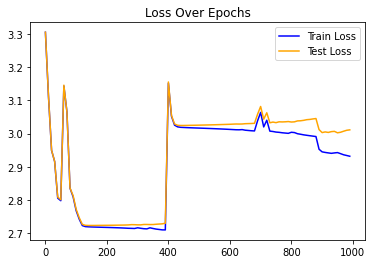

In [9]:
# Plot Losses
epochs = np.arange(0,epoch,PRINT_DELAY)
plt.title("Loss Over Epochs")
plt.plot(epochs,train_losses,c="blue",label="Train Loss")
plt.plot(epochs,test_losses,c="orange",label="Test Loss")
plt.legend()
plt.show()

In [10]:
# Forward pass examples
test_examples, test_example_loss = sess.run([outputs, cost], test_feed_dict)
train_examples, train_example_loss = sess.run([outputs, cost], train_feed_dict)

if ONE_HOT:
    # OHE to Vocab
    ones_test = np.full((test_examples.shape[0],1),1)
    ones_train = np.full((train_examples.shape[0],1),1)
    ones_y_test = np.full((y_test.shape[0],1),1)
    ones_y_train = np.full((y_train.shape[0],1),1)
    vocab_test = np.argmax(np.around(test_examples),2)[:,:-1]
    vocab_train = np.argmax(np.around(train_examples),2)[:,:-1]
    vocab_y_test = np.argmax(np.around(y_test),2)[:,:-1]
    vocab_y_train = np.argmax(np.around(y_train),2)[:,:-1]
    test_examples = np.concatenate((ones_test,vocab_test),1)
    train_examples = np.concatenate((ones_train,vocab_train),1)
    test_y_examples = np.concatenate((ones_y_test,vocab_y_test),1)
    train_y_examples = np.concatenate((ones_y_train,vocab_y_train),1)
else:
    test_y_examples =  np.copy(y_test)
    train_y_examples = np.copy(y_train)

# Decode examples and simulate
decoded_test = []
decoded_train = []
for i in range(train_examples.shape[0]):
    if i<=test_examples.shape[0]:
        encoded_test = np.concatenate((np.array([1]),test_examples[i].flatten()[:-2],np.array([2])))
        decoded_test.append(decode_circuit(encoded_test,N))
    encoded_train = np.concatenate((np.array([1]),train_examples[i].flatten()[:-2],np.array([2])))
    decoded_train.append(decode_circuit(encoded_train,N))
test_labels = generate_labels(decoded_test)
train_labels = generate_labels(decoded_train)

# Compute Metrics
test_sequence_loss=np.mean(np.mean(test_examples!=test_y_examples,axis=1))
test_target_loss=np.mean(np.mean((c_test-test_labels)**2,axis=1))
train_sequence_loss=np.mean(np.mean( train_examples!=train_y_examples,axis=1))
train_target_loss=np.mean(np.mean((c_train-train_labels)**2,axis=1))

# Print
print("Sequence Loss (test/train):",test_sequence_loss,"/",train_sequence_loss)
print("Target Loss   (test/train):",test_target_loss,"/",train_target_loss)
print("RNN Loss      (test/train):",test_example_loss,"/",train_example_loss)

Sequence Loss (test/train): 0.8488666666666667 / 0.8368833333333334
Target Loss   (test/train): 0.01822529111875 / 0.018000755643749998
RNN Loss      (test/train): 3.012438 / 2.93093


In [41]:
# Demonstrate example
i=np.random.randint(test_examples.shape[0])
print(np.around(test_examples[i]).T)
print(test_y_examples[i].T)
print(test_labels[i])
print(c_test[i])
decoded_test[i].draw()

# Draw histogram of predicted gates
# plt.hist(np.around(test_examples.flatten()))

[1 6 6 3 3 3 3 3 3 3 3 0]
[ 1  9  3 10 11  7  3  9 22  3  6  2]
[ 0.707  0.707  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.    -0.    -0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.   ]
[ 0.354  0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.    -0.354  0.     0.     0.     0.     0.     0.     0.
 -0.354  0.     0.     0.    -0.354  0.     0.     0.    -0.     0.
  0.     0.    -0.     0.     0.     0.     0.354  0.     0.     0.
  0.354  0.     0.     0.     0.     0.     0.     0.     0.354  0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 -0.354  0.     0.     0.   ]


┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐
q_0: |0>┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├┤ H ├
        └───┘└───┘└───┘└───┘└───┘└───┘└───┘
q_1: |0>───────────────────────────────────
                                           
q_2: |0>───────────────────────────────────
        ┌───┐┌───┐                         
q_3: |0>┤ H ├┤ H ├─────────────────────────
        └───┘└───┘                         
q_4: |0>───────────────────────────────────

##### Audio Notification of Completion (Option)

In [0]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

#### _Yoav Rabinovich, March 2020_

--------------------------------